# DevDay 02: Challenges with real-world data

In [1]:
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt 

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("."), "..")))
#
# from data.electricity_consumption import energy_demand
from data.india_pollution import india_pollution
from data.dataset import Dataset

## Missing and irregularly spaced data


In [12]:
# load the data
dataset_object = next(india_pollution(city_list=["Chennai"], raw=True))

# get the data from the Dataset object
data = dataset_object.values

print(data.head())



INFO:root:Path /Users/frankkelly/Dropbox/Projects-new/india_air_pollution_study/data/air-quality-data-in-india exists
INFO:root:Getting list of city names
INFO:root:Path /Users/frankkelly/Dropbox/Projects-new/india_air_pollution_study/data/air-quality-data-in-india exists


            PM2.5  PM10     O3    CO    SO2    NO2
Date                                              
2015-01-01    NaN   NaN  11.35  1.17   9.20  15.39
2015-01-02    NaN   NaN   9.16  1.23   8.61  13.42
2015-01-03    NaN   NaN  13.45  0.77  48.23  19.56
2015-01-04    NaN   NaN  10.33  1.00  27.96  16.20
2015-01-05    NaN   NaN   9.36  0.90  16.60  16.30


In [13]:
def plot_indian_city_pollution(df: pd.DataFrame, title: str = "Indian city pollution", scale: bool = False, chosen_metric: str = "PM2.5") -> None:
    """Plots the Indian pollution DataFrame, highlighting any gaps in the data."""
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Find the gaps in the data
    gap = df[chosen_metric].isnull().astype(int)
    gaps = gap[gap == 1]
    
    plt.plot(df.index, df[chosen_metric])
    
    # Highlight gaps in the data
    if gaps.shape[0] > 0:
        for gap_start, gap_end in zip(gaps.index[:-1], gaps.index[1:]):
            if gap_start != gap_end:
                ax.axvspan(gap_start, gap_end, color='red', alpha=0.2)
    else:
        print("No gaps in data")
    
    plt.xlabel("Date")
    if scale:
        plt.ylabel(f"{chosen_metric}, scaled")
    else:
        plt.ylabel(f"{chosen_metric}, micrograms per cubic meter")


    # Add a legend including the red area
    if gaps.shape[0] > 0:
        plt.legend([f"{chosen_metric}", "Missing data"])
    else:
        plt.legend([f"{chosen_metric}"])

    plt.title(title)
    plt.show()

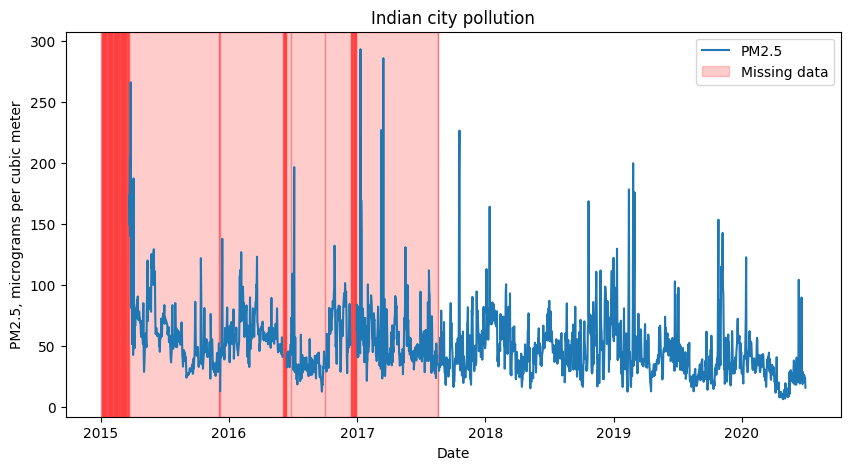

In [14]:
plot_indian_city_pollution(data, scale=False)

In [6]:
# show the data
data.head()

zone,CT
ts,
2003-03-02,3254.000000
2003-03-09,3328.714286
2003-03-16,3268.714286
2003-03-23,2805.571429
2003-03-30,2732.285714


In [7]:
# What are the data types?
data.dtypes



zone
CT    float64
dtype: object

In [8]:
# Check that the index of the Pandas DataFrame is a DatetimeIndex

print(f"Type of index: {type(data.index)}")

# show us what that looks like
print(data.index[:5])

Type of index: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2003-03-02', '2003-03-09', '2003-03-16', '2003-03-23',
               '2003-03-30'],
              dtype='datetime64[ns]', name='ts', freq='W-SUN')


In [9]:
# show us the frequency of the data
print(f"Frequency of data: {data.index.freq}")

# What does weekday=6 mean?
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.weekday.html
data.index.weekday[:5]

Frequency of data: <Week: weekday=6>


Int64Index([6, 6, 6, 6, 6], dtype='int64', name='ts')

## Splitting into training and test sets

**Why We Don't Shuffle Time Series Data Before Splitting**

In time series analysis, it's important to maintain the temporal order of the data when splitting into training and testing sets. This is because the inherent chronological order helps capture underlying patterns and trends that are essential for accurate forecasting.

Shuffling time series data before splitting disrupts this order and compromises the model's ability to accurately predict future events based on historical information. Therefore, when working with time series data, ensure that the training set consists of the initial, contiguous portion of the data, and the testing set is the subsequent, contiguous portion. This method preserves the historical context necessary for the model to make accurate predictions.

In [10]:
# Here we split the data into training and test sets
# We will use the first 80% of the data for training
# and the last 20% for testing

# get the length of the data
length = len(data)

# get the index of the last training data point
last_training_index = int(length * 0.8)

# get the index of the first test data point
first_test_index = last_training_index + 1

# get the training data
training_data = data.iloc[:last_training_index]

# get the test data
test_data = data.iloc[first_test_index:]


In [11]:
# or a quicker way to do the same thing with SciKit-Learn

from sklearn.model_selection import train_test_split

# split the data into training and test sets
training_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

## Perform Exploratory Data Analysis
Using techniques like autocorrelation plots, partial autocorrelation plots, and decomposition to further understand the time series data.
(This is more advanced)

In [12]:
# Autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# what's the number of lags we want to plot?
number_of_lags = 52



## Cheatsheet for determining the number of lags

Here's a table for determining the number of lags to plot for ACF and PACF based on the frequency and domain type of your data. Note that the number of lags for ACF and PACF plots can be the same, but you may choose to adjust them based on the specific characteristics of your data.

### Lags by frequency of dataset

| Frequency Type  | Suggested Number of Lags for ACF & PACF | Justification                                             |
|-----------------|-----------------------------------------|------------------------------------------------------------|
| Daily data      | 30                                      | Covers about one month, capturing short-term dependencies  |
| Weekly data     | 52                                      | Covers an entire year, capturing seasonal patterns         |
| Monthly data    | 24                                      | Covers two years, capturing yearly and bi-yearly patterns  |
| Quarterly data  | 8                                       | Covers two years, capturing yearly patterns                |
| Annual data     | 10                                      | Covers a decade, capturing long-term patterns              |


### Lags by dataset domain

| Domain Type          | Frequency   | Suggested Number of Lags for ACF & PACF | Justification                                         |
|----------------------|-------------|-----------------------------------------|-------------------------------------------------------|
| Finance (e.g., stocks)| Daily       | 20-30                                   | Captures short-term trends and potential seasonal effects  |
| Climate (e.g., temperature) | Monthly | 30-50                             | Captures both seasonal patterns and long-term trends       |
| Macro-economics      | Quarterly   | 10-20                                   | Captures business cycle fluctuations and long-term trends  |
| Retail sales         | Monthly     | 12                                      | Captures seasonal patterns and promotions effects         |
| Energy consumption   | Hourly      | 24-168                                  | Captures daily and weekly patterns in energy usage         |


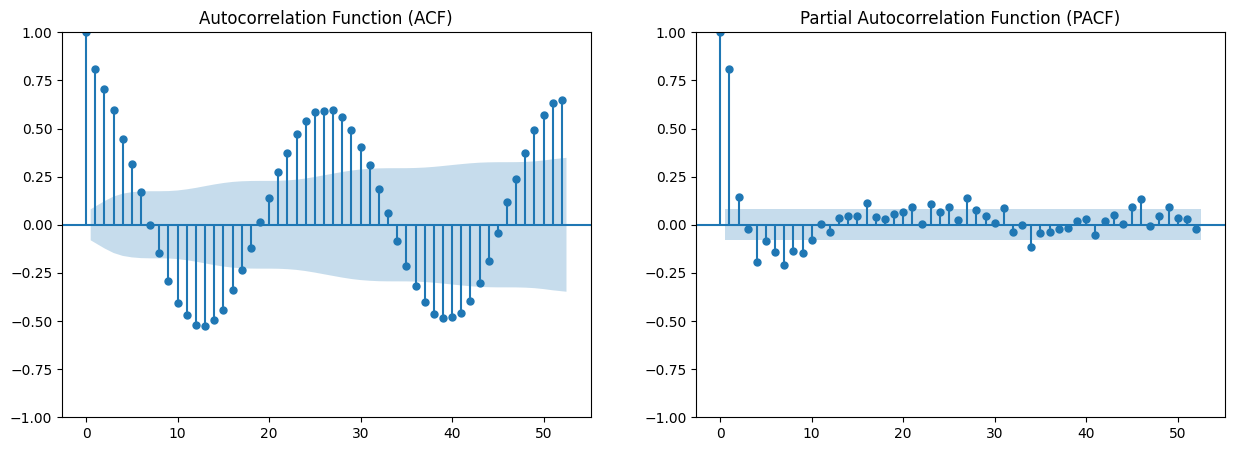

In [13]:

# what's the number of lags we want to plot?
number_of_lags = 52


# plot the autocorrelation and partial autocorrelation plots nicely side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(training_data, ax=ax1, lags=number_of_lags)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(training_data, ax=ax2, lags=number_of_lags, method="ywm")
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.show()

## Cheat sheet for interpreting ACF and PACF plots

| Plot   | Pattern                                | Interpretation                             |
|--------|----------------------------------------|--------------------------------------------|
| ACF    | Gradual decline                        | Autoregressive (AR) component may be present |
| ACF    | Drops off quickly and remains near zero | Moving average (MA) component may be present |
| ACF    | Oscillating                            | Seasonal component may be present           |
| PACF   | Sharp drop after a certain lag         | AR component with an order equal to that lag |
| PACF   | Gradual decline                        | MA component may be present                |



When the ACF plot exhibits an oscillating pattern, it may indicate the presence of a seasonal component in the time series. In such cases, you may want to consider using a seasonal model (e.g., SARIMA) or a model that can capture seasonality (e.g., Facebook's Prophet, LSTM with seasonal input features).

## Seasonal decomposition

### Is the model additive or multiplicative?

**Additive vs Multiplicative Seasonality**

In time series data, seasonality can be either additive or multiplicative. The key difference between the two lies in how the seasonal component interacts with the data.

**Additive Seasonality:** The seasonal component is added to the trend and other components of the time series. The amplitude of the seasonal pattern remains constant over time, and fluctuations in the data are relatively constant or change linearly. 

Example: Sales of a product remain stable throughout the year but increase by a fixed amount during the holiday season.

**Multiplicative Seasonality:** The seasonal component is multiplied by the trend and other components of the time series. The amplitude of the seasonal pattern increases or decreases over time, and fluctuations in the data change exponentially. 

Example: Sales of a product increase over time, but the percentage increase during the holiday season is consistent, leading to larger absolute increases in sales as the trend grows.


| Characteristic                 | Additive Seasonality                 | Multiplicative Seasonality          |
|--------------------------------|--------------------------------------|-------------------------------------|
| Seasonal pattern amplitude     | Remains constant over time           | Increases or decreases over time    |
| Fluctuations in data           | Remain constant or change linearly   | Change exponentially                |
| Data transformation            | No transformation required           | Log transformation stabilizes pattern |


Q: Can I determine whether the model is additive or multiplicative automatically?  
\
    Automatically determining the seasonality type is not straightforward. You can try fitting both additive and multiplicative models and compare their performances using a metric like AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion). The model with the lower value of the chosen metric is generally preferred.
    
Q. What is "period"?

| Frequency | Seasonal Value |
|-----------|----------------|
| Yearly    | 12             |
| Quarterly| 4              |
| Monthly  | 12             |
| Weekly    | 52             |
| Daily     | 7              |


The `period` argument specifies the periodicity of the seasonal component, i.e. the number of observations per season. This parameter is used to inform the decomposition algorithm about the expected pattern of seasonality in the data, and can be particularly useful when dealing with non-integer seasonalities. For example, if the data has a seasonal pattern that repeats every 12.5 months, setting period=12 or period=13 would not be appropriate, but setting period=25 would capture the correct seasonal pattern.







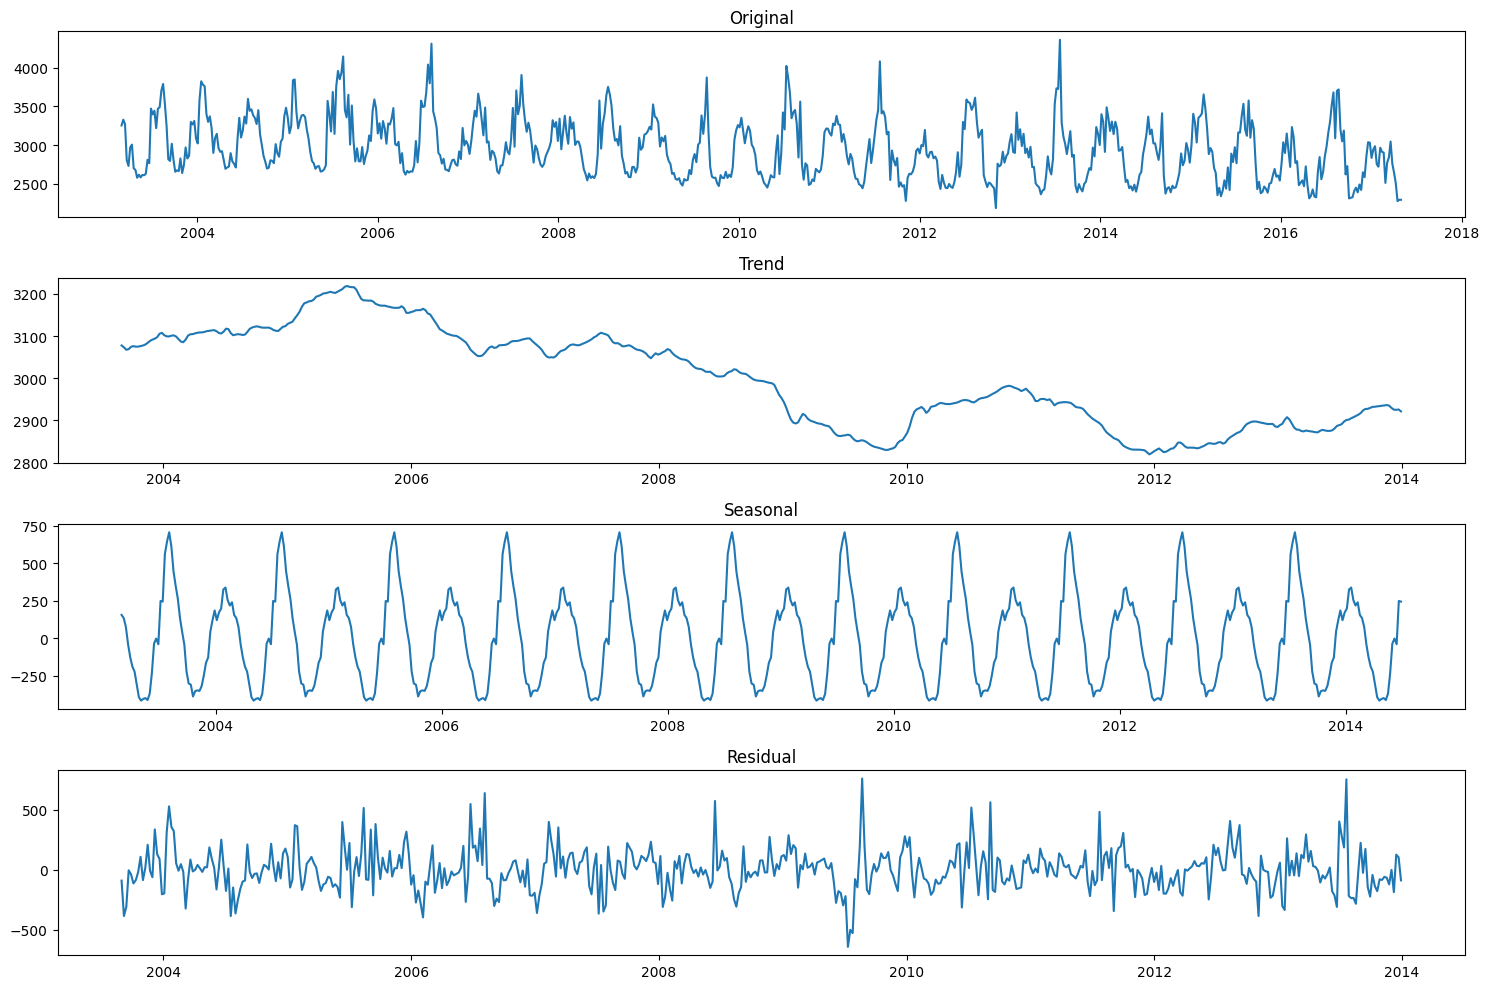

In [14]:
# Decomposing the time series - additive model

from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series
decomposition_additive = seasonal_decompose(training_data, model="additive", period=52)

# plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
ax1.plot(data)
ax1.set_title("Original")
ax2.plot(decomposition_additive.trend)
ax2.set_title("Trend")
ax3.plot(decomposition_additive.seasonal)
ax3.set_title("Seasonal")
ax4.plot(decomposition_additive.resid)
ax4.set_title("Residual")
plt.tight_layout()
plt.show()




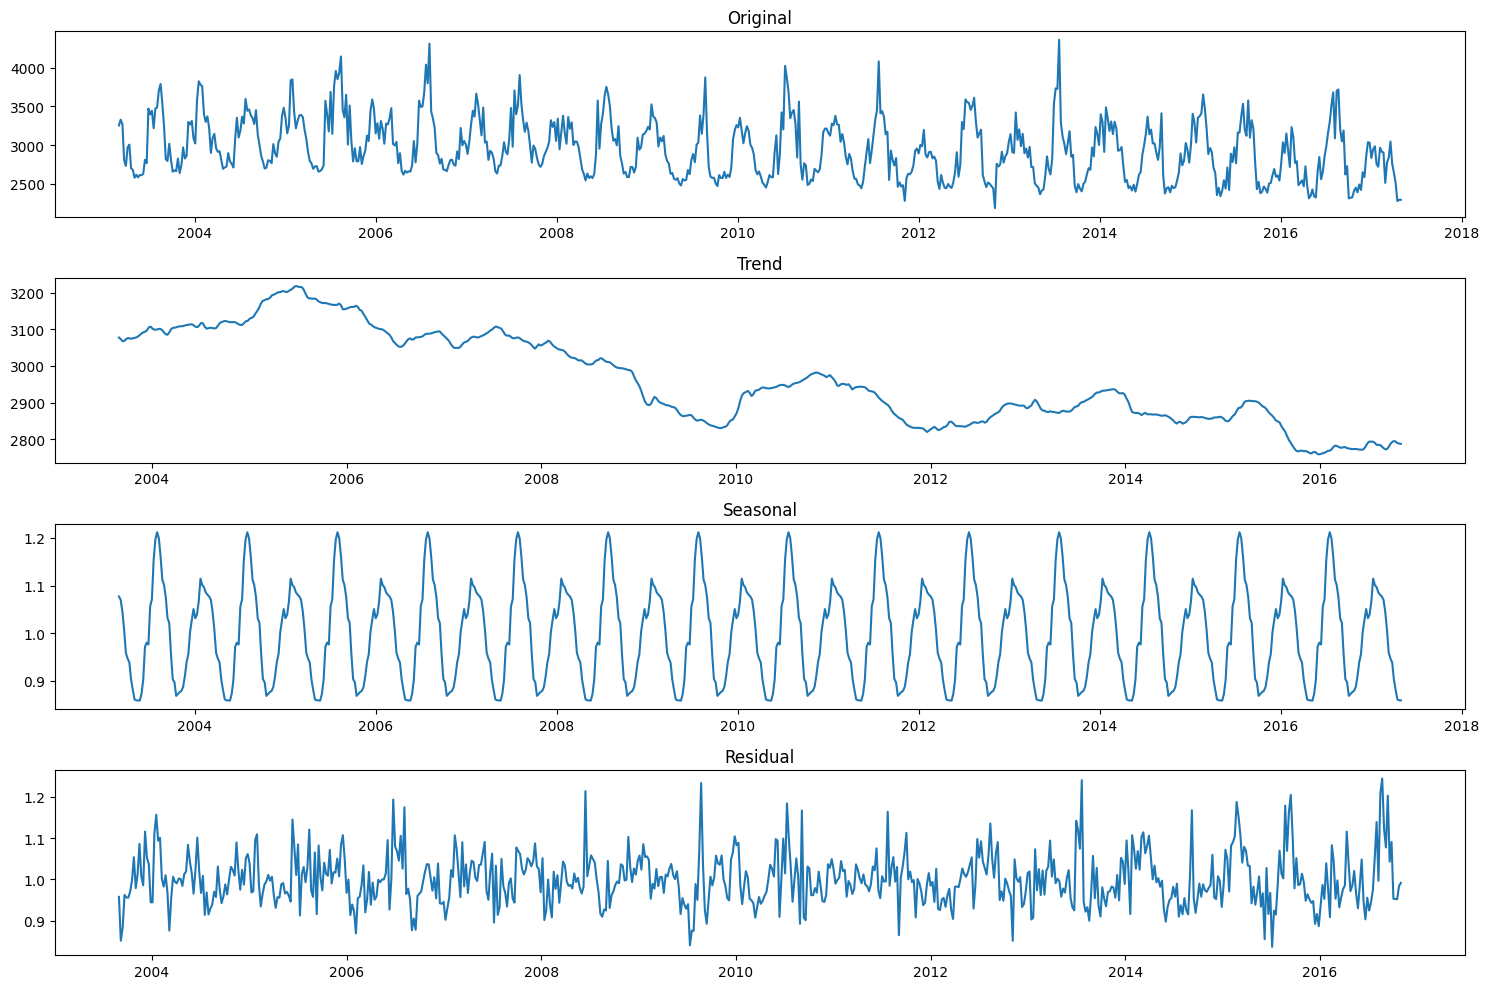

In [15]:
# Decomposing the time series - multiplicative model

# decompose the time series
decomposition_multiplicative = seasonal_decompose(data, model="multiplicative", period=52)

# plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
ax1.plot(data)
ax1.set_title("Original")
ax2.plot(decomposition_multiplicative.trend)
ax2.set_title("Trend")
ax3.plot(decomposition_multiplicative.seasonal)
ax3.set_title("Seasonal")
ax4.plot(decomposition_multiplicative.resid)
ax4.set_title("Residual")
plt.tight_layout()
plt.show()



## More advanced approach to seasonal decomposition; using STL

Q: What's the difference between the seasonal and the period arguments in statsmodels.tsa.seasonal.STL?

| Frequency | Seasonal | Period |
|-----------|----------|--------|
| Hourly    | 24       | 24     |
| Daily     | 7        | 365    |
| Weekly    | 52       | 52     |
| Monthly   | 12       | 12     |
| Quarterly | 4        | 4      |
| Yearly    | 1        | 1      |


The seasonal argument specifies the number of observations in each seasonal period (e.g. 24 hours in a day for hourly data), while the period argument specifies the number of observations in a complete cycle of seasonality (e.g. 168 hours in a week for hourly data).



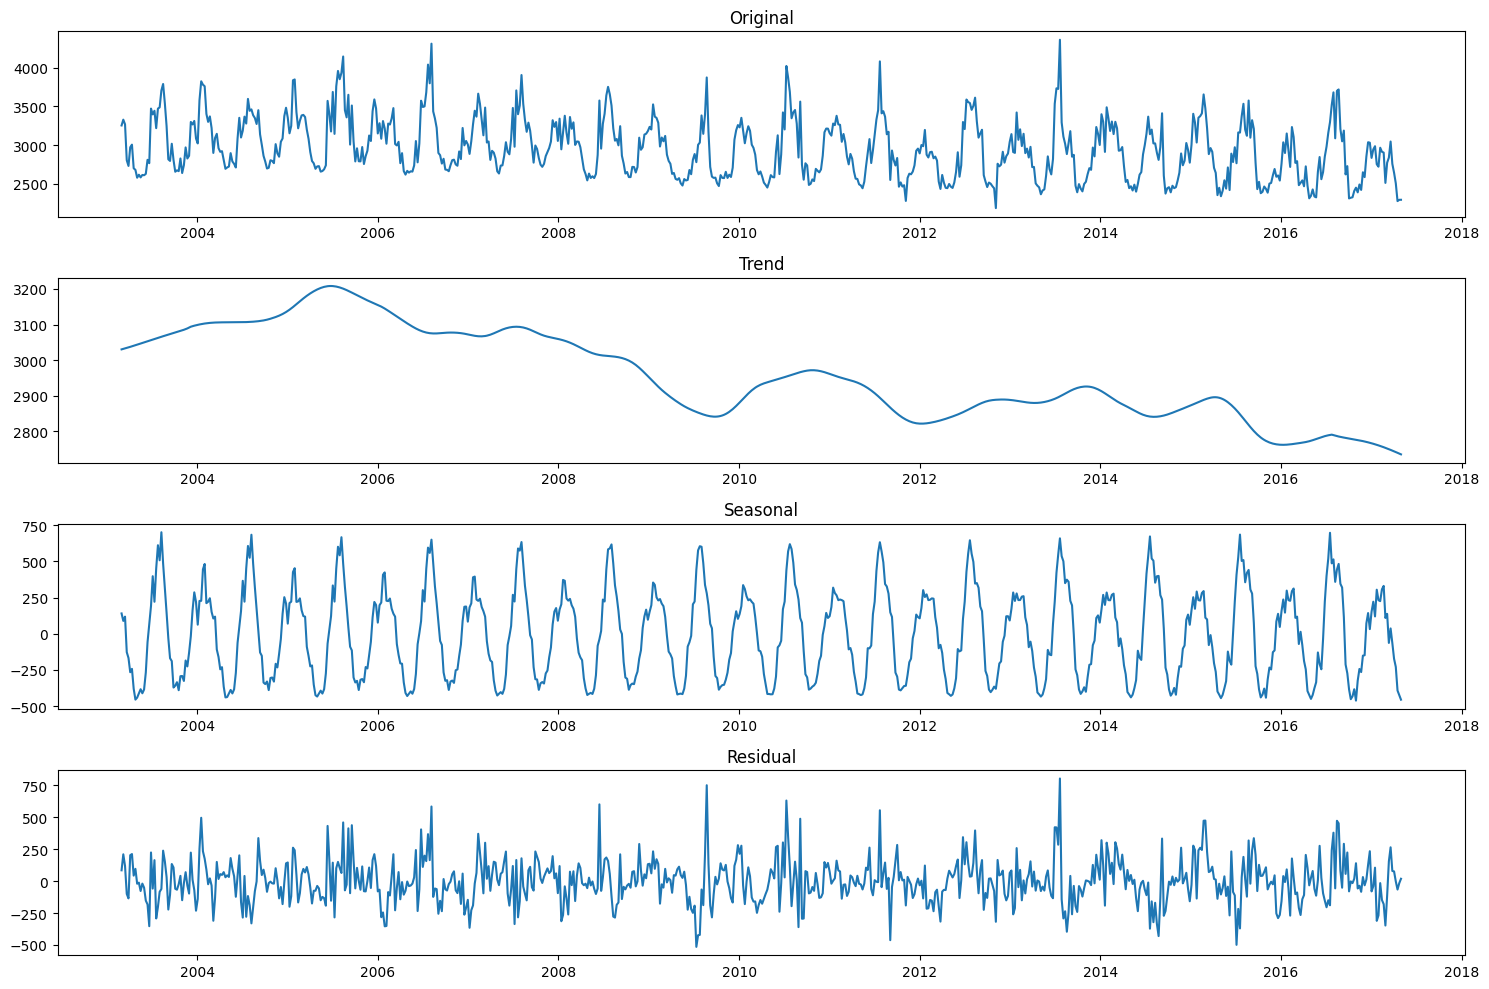

In [16]:
# Seasonal decomposition using the STL method

from statsmodels.tsa.seasonal import STL

# decompose the time series
decomposition_STL = STL(data, seasonal=53, period=52).fit()

# plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
ax1.plot(data)
ax1.set_title("Original")
ax2.plot(decomposition_STL.trend)
ax2.set_title("Trend")
ax3.plot(decomposition_STL.seasonal)
ax3.set_title("Seasonal")
ax4.plot(decomposition_STL.resid)
ax4.set_title("Residual")
plt.tight_layout()
plt.show()



## Real-world challenge: electricity consumption
Some common challenges faced when working with time series data in the real world

